### Univariate profiles

In [1]:
from pathlib import Path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif
from palettable.scientific.sequential import Nuuk_3 as ColMap
from fmri_decoder.data import SurfaceData
from src.data import Data
from src.config import SUBJECTS, SESSION, N_LAYER
from src.stats import Bootstrap
plt.style.use(os.path.join(module_path, "src", "default.mplstyle"))

DIR_DATA = "/data/pt_01880/Experiment1_ODC/paper/decoding"
FILTER_SIZE = "none"

# set
SESS = "VASO"
METRIC = "psc"
NMAX = 200

In [2]:
def get_label(subj):
    # get label and hemisphere
    data = Data(subj, [])
    surf_data = SurfaceData(data.file_layer, None, data.file_label)

    label_left = surf_data.load_label_intersection("lh")
    label_right = surf_data.load_label_intersection("rh")

    hemi = np.zeros(len(label_left)+len(label_right))
    hemi[len(label_left):] = 1
    label = np.append(label_left, label_right)

    return label, hemi

def select_features(dtf, label, hemi):
    # choose subset of features
    features = dtf.columns[2:]
    
    X = np.array(dtf.loc[:, features])
    y = np.array(dtf.loc[:, "label"])

    f_statistic = f_classif(X, y)[0]
    index = np.arange(len(features))
    index_sorted = np.array(
                [x for _, x in sorted(zip(f_statistic, index), reverse=True)]
            )
    index_sorted = index_sorted[: NMAX]

    label_selected = label[index_sorted]
    hemi_selected = hemi[index_sorted]

    return label_selected, hemi_selected

def get_profile(sess, day):
    # get data profiles
    y = np.zeros((N_LAYER, len(SUBJECTS)))
    for i, subj in enumerate(SUBJECTS):
        label, hemi = get_label(subj)
        for j in range(N_LAYER):
            data = Data(subj, f"{sess}{SESSION[subj][sess][day]}")
            dtf = pd.read_parquet(data.get_sample_data(j))
            label_selected, hemi_selected = select_features(dtf, label, hemi)

            if METRIC == "tsnr":
                arr_left = data.get_tsnr("lh", j)
                arr_right = data.get_tsnr("rh", j)
            elif METRIC == "cnr":
                arr_left = data.get_cnr("lh", j)
                arr_right = data.get_cnr("rh", j)
            elif METRIC == "psc":
                arr_left = data.get_psc("lh", j)
                arr_right = data.get_psc("rh", j)
            elif METRIC == "rest":
                arr_left = data.get_rest("lh", j)
                arr_right = data.get_rest("rh", j)
            else:
                ValueError("Unknown metric!")

            tmp = np.concatenate((arr_left[label_selected[hemi_selected==0]], 
                                  arr_right[label_selected[hemi_selected==1]]), axis=0)
            y[j, i] = np.mean(tmp)
    return y

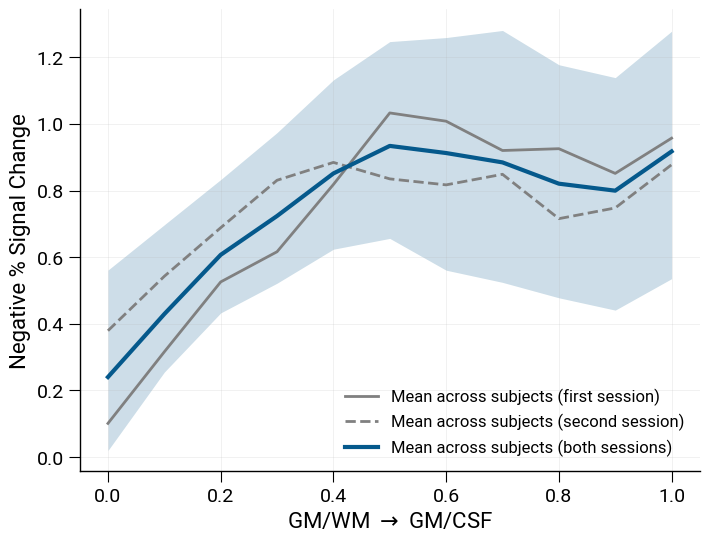

In [5]:
x = np.linspace(0, 1, N_LAYER)
y1 = get_profile(SESS, 0)
y2 = get_profile(SESS, 1)
y3 = np.append(y1, y2, axis=1)
if SESS == "VASO":
    y1 *= -1
    y2 *= -1
    y3 *= -1
#np.savez(Path("/data/pt_01880") / f"{METRIC}_{SESS}.npy", y1=y1, y2=y2, y3=y3)

ci_low = []
ci_high = []
for i in range(N_LAYER):
    boot = Bootstrap(y3[i,:])
    low, high = boot.confidence_interval()
    ci_low.append(low)
    ci_high.append(high)

fig, ax = plt.subplots()
color = ColMap.hex_colors
ax.plot(x, np.mean(y1, axis=1), color="gray", linestyle="-", label="Mean across subjects (first session)")
ax.plot(x, np.mean(y2, axis=1), color="gray", linestyle="--", label="Mean across subjects (second session)")
ax.plot(x, np.mean(y3, axis=1), color=color[0], linestyle="-", label="Mean across subjects (both sessions)", lw=3)
ax.fill_between(x, ci_low, ci_high, color=color[0], alpha=0.2, lw=0)
ax.set_xlabel(r"GM/WM $\rightarrow$ GM/CSF")
if SESS == "VASO":
    ax.set_ylabel("Negative % Signal Change")
else:
    ax.set_ylabel("% Signal Change")
ax.legend(loc="lower right")
file_out = f"/data/pt_01880/{METRIC}_{SESS}.svg"
#fig.savefig(file_out, dpi=300, bbox_inches="tight", transparent=True, format="svg")